In [2]:
from re import S
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, classification_report
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

# df = pd.read_csv('Weather Data (US).csv', nrows=1000)
# print(df['PRCP'].isna().sum())
# print(df.head())

# df['PRCP'] = df['PRCP'].interpolate()
# print(df.head())

sns.set(style="whitegrid")
def plot_per_station(df):
    station_mapping = dict(zip(df['STATION'], df['STATION_NAME']))

    for station in df['STATION'].unique():
        station_data = df[df['STATION'] == station]
        station_data['DATE'] = pd.to_datetime(station_data['DATE'], format='%Y%m%d %H:%M')

        fig, axes = plt.subplots(2, 2, figsize=(24, 10))

        # plot 1: precipitation over time
        axes[0, 0].plot(station_data['DATE'], station_data['HPCP'], label=f"Precipitation for {station_mapping[station]}", color="blue")
        axes[0, 0].set_title(f"Precipitation over Time for {station_mapping[station]}", fontsize=14)
        axes[0, 0].set_xlabel("Date")
        axes[0, 0].set_ylabel("Precipitation (inches)")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # plot 2: monthly precipitation (seasonal trend)
        station_data['Month'] = station_data['DATE'].dt.month
        monthly_precip = station_data.groupby('Month')['HPCP'].sum()
        axes[0, 1].bar(monthly_precip.index, monthly_precip.values, color="green")
        axes[0, 1].set_title(f"Monthly Precipitation for {station_mapping[station]}", fontsize=14)
        axes[0, 1].set_xlabel("Month")
        axes[0, 1].set_ylabel("Total Precipitation (inches)")
        axes[0, 1].set_xticks(np.arange(1, 13))

        # Plot 3: Seasonal decomposition using seasonal_decompose
        # Set 'DATE' as index for the seasonal_decompose function
        station_data.set_index('DATE', inplace=True)

        # Use seasonal_decompose for the HPCP column, assuming annual seasonality
        result = seasonal_decompose(station_data['HPCP'], model='additive', period=365)  # period=365 for annual seasonality

        # Plot the decomposition result
        axes[1, 0].plot(result.observed, label="Observed Data", color='blue')
        axes[1, 0].set_title(f"Observed Data (Precipitation) for {station_mapping[station]}")
        axes[1, 0].set_xlabel("Date")
        axes[1, 0].set_ylabel("Precipitation (inches)")

        axes[1, 1].plot(result.trend, label="Trend", color='green')
        axes[1, 1].set_title(f"Trend Component for {station_mapping[station]}")
        axes[1, 1].set_xlabel("Date")
        axes[1, 1].set_ylabel("Precipitation (inches)")

        plt.subplots_adjust(hspace=0.3, wspace=0.3)
        # plot 4: autocorrelation plot
        # autocorrelation helps to see if there are any correlations with previous values (helpful for ARIMA models)
        fig_acf, ax_acf = plt.subplots(figsize=(10, 6))
        autocorrelation_plot(station_data['HPCP'], ax=ax_acf)
        ax_acf.set_title(f"Autocorrelation for {station_mapping[station]}", fontsize=14)

        plt.tight_layout()
        plt.show()


def preprocess_for_ml(df):
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d %H:%M')

    #remove missing or invalid data for precipitation
    df['HPCP'] = df['HPCP'].replace(999.99, np.nan)
    df['HPCP'] = df['HPCP'].interpolate(method='linear')
    df = df.dropna(subset=['HPCP'])

    df = df.copy()

    #create additional time-based features
    df.loc[:, 'hour'] = df['DATE'].dt.hour
    df.loc[:, 'day_of_week'] = df['DATE'].dt.dayofweek
    df.loc[:, 'month'] = df['DATE'].dt.month

    #create elevation binning feature(low, med, high)
    bins = [0, 500, 1000, 2000, 3000, np.inf]
    labels = ['0-500m', '500-1000m', '1000-2000m', '2000-3000m', '3000+m']
    df.loc[:, 'elevation_range'] = pd.cut(df['ELEVATION'], bins=bins, labels=labels)


    #drop cols for are not necessary
    df = df.drop(columns=['STATION', 'STATION_NAME', 'Measurement Flag', 'Quality Flag'])

    return df


def add_lag_features(df, lag=1):
    df['HPCP_lag'] = df['HPCP'].shift(lag)
    df = df.dropna()
    return df


# decision tree and XGBoost regression models
def train_regression_model(df, use_elevation=True):
    #select features & target
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['HPCP']

    #split dataset into training & test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    #model 1: decision tree regressor
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    #predict on dataset
    y_pred = dt_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Decision Tree Mean Squared Error: {mse}")

    #model 2: XGBoost Regressor
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)
    #predict on dataset
    y_pred_xgb = xgb_model.predict(X_test)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)
    print(f"XGBoost Mean Squared Error: {mse_xgb}")


# classification model for heavy rain prediction
def classify_heavy_rain_xgb(df, threshold=0.3, use_elevation=True):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['heavy_rain']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #apply SMOTE to the training set to balance the classes
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()


    # Model: XGBoost Classifier
    xgb_class_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)
    xgb_class_model.fit(X_train, y_train)


    y_pred_proba = xgb_class_model.predict_proba(X_test)[:, 1]
    y_pred_class = (y_pred_proba > threshold).astype(int)  # Apply threshold

    # Evaluate the model
    print(classification_report(y_test, y_pred_class))


def main():
    print("---PRECIPITATION DATA FOR MA---\n")
    #load & preprocess data
    #change this based on local or in drive, but will always refer to precipitation_data.csv
    df = pd.read_csv('/content/drive/MyDrive/precipitation_data.csv')
    print(f"Prefiltered length: {len(df)}")
    print(df)

    cleaned_df = preprocess_for_ml(df)
    # plot_per_station(cleaned_df)
    cleaned_df = add_lag_features(cleaned_df)

    print(f"Filtered length: {len(cleaned_df)}")
    print(cleaned_df)

    print("------------------------\n")

    #modeling without elevation feature
    print("MODELING WITHOUT ELEVATION")

    print("Training Regression Model...")
    train_regression_model(cleaned_df, use_elevation=False)

    print("\n")

    print("Training XGBoost Classifier for Heavy Rain Prediction...")
    classify_heavy_rain_xgb(cleaned_df, threshold=0.3, use_elevation=False)

    print("------------------------\n")

    #modeling with elevation feature
    print("MODELING WITH ELEVATION")

    print("Training Regression Model...")
    train_regression_model(cleaned_df)

    print("\n")

    print("Training XGBoost Classifier for Heavy Rain Prediction...")
    classify_heavy_rain_xgb(cleaned_df, threshold=0.3)

    print("------------------------\n")


if __name__ == '__main__':
    main()

---PRECIPITATION DATA FOR MA---

Prefiltered length: 39413
           STATION           STATION_NAME  ELEVATION  LATITUDE  LONGITUDE  \
0      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
1      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
2      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
3      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
4      COOP:190408  BARRE FALLS DAM MA US      277.4  42.43333  -72.03333   
...            ...                    ...        ...       ...        ...   
39408  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39409  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39410  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39411  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   
39412  COOP:190736   BLUE HILL COOP MA US      190.5  42.21230  -71.11370   

                

------------------------

MODELING WITHOUT ELEVATION
Random Forest Regressor for Precipitation Prediction...
Mean Squared Error: 0.005194301129607565
R-squared: 0.2992298381460837


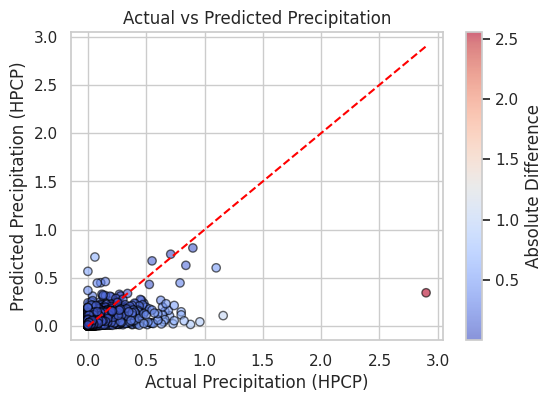

------------------------

MODELING WITH ELEVATION
Random Forest Regressor for Precipitation Prediction...
Mean Squared Error: 0.005207887774739411
R-squared: 0.2973968455508288


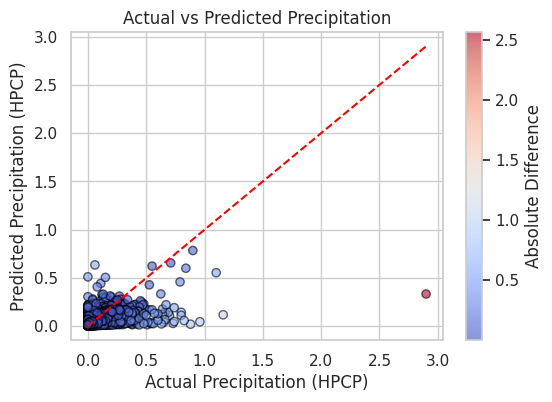

------------------------



In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV


# classification model for heavy rain prediction
def classify_heavy_rain_random_forest(df, threshold=0.3, use_elevation=True):
  # binary target: 1 for heavy rain (precip > threshold), 0 for no heavy rain
    df['heavy_rain'] = (df['HPCP'] > threshold).astype(int)

    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')
    X = df[features]
    y = df['heavy_rain']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #apply SMOTE to the training set to balance the classes
    smote = BorderlineSMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


    rf_model = RandomForestClassifier(class_weight='balanced', random_state=42,
                                      max_depth=10, min_samples_leaf=2,
                                      min_samples_split=10, n_estimators=100)



    #USED TO FIND BEST parameters
    # param_grid = {
    #     'n_estimators': [100, 200, 300],
    #     'max_depth': [3, 5, 7, 10],
    #     'min_samples_split': [2, 5, 10],
    #     'min_samples_leaf': [1, 2, 4]
    # }
    # grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='precision')
    # grid_search.fit(X_train_res, y_train_res)
    # print("Best hyperparameters:", grid_search.best_params_)
    # rf_model = grid_search.best_estimator_



    rf_model.fit(X_train_res, y_train_res)
    #predict probabilites instead of labels
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

     # Adjust threshold for classifying as heavy rain (class 1)
    y_pred_rf = (y_pred_proba > 0.7).astype(int)
    print(classification_report(y_test, y_pred_rf))


def plot_actual_vs_predicted(y_true, y_pred, title="Actual vs Predicted Precipitation"):

    diff = np.abs(y_true - y_pred)

    plt.figure(figsize=(6, 4))
    scatter = plt.scatter(y_true, y_pred, c=diff, cmap='coolwarm', alpha=0.6, edgecolors='black')

    plt.colorbar(scatter, label='Absolute Difference')

    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')

    plt.xlabel('Actual Precipitation (HPCP)')
    plt.ylabel('Predicted Precipitation (HPCP)')
    plt.title(title)

    plt.show()



def precipitation_random_forest_regressor(df, use_elevation=True):
    features = ['LATITUDE', 'LONGITUDE', 'hour', 'day_of_week', 'month', 'HPCP_lag']
    if use_elevation:
        features.append('ELEVATION')

    X = df[features]
    y = df['HPCP']  # Predict HPCP, not the binary target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    rf_model = RandomForestRegressor( n_estimators=200,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        max_depth=10,
        bootstrap=True,
        random_state=42)

    #  param_dist = {
    #     'n_estimators': [100, 200, 300, 500],  # Number of trees
    #     'max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    #     'min_samples_split': [2, 5, 10, 20],  # Minimum samples required to split an internal node
    #     'min_samples_leaf': [1, 2, 4, 10],  # Minimum samples required to be at a leaf node
    #     'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for each split
    #     'bootstrap': [True, False]  # Whether to use bootstrap samples for building trees
    # }

    # random_search = RandomizedSearchCV(estimator=rf_model,
    #                                   param_distributions=param_dist,
    #                                   n_iter=50,  # Number of random combinations to sample
    #                                   cv=5,  # 5-fold cross-validation
    #                                   verbose=2,  # Increase verbosity for better insight
    #                                   random_state=42,
    #                                   n_jobs=-1,  # Use all available CPU cores
    #                                   scoring='neg_mean_squared_error')  # Use negative MSE for regression

    # # Fit the RandomizedSearchCV to the training data
    # random_search.fit(X_train, y_train)

    # print("Best hyperparameters found: ", random_search.best_params_)


    # best_rf_model = random_search.best_estimator_




    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')
    plot_actual_vs_predicted(y_test, y_pred, title="Actual vs Predicted Precipitation")






def main():
    df = pd.read_csv('/content/drive/MyDrive/precipitation_data.csv')
    cleaned_df = preprocess_for_ml(df)
    cleaned_df = add_lag_features(cleaned_df)


    # print("------------------------\n")

    # #modeling without elevation feature
    # print("MODELING WITHOUT ELEVATION")

    # print("Random Forests for Heavy Rain Prediction...")
    # classify_heavy_rain_random_forest(cleaned_df, threshold=0.3, use_elevation=False)

    # print("------------------------\n")

    # #modeling with elevation feature
    # print("MODELING WITH ELEVATION")


    # print("Random Forests for Heavy Rain Prediction...")
    # classify_heavy_rain_random_forest(cleaned_df, threshold=0.3)

    # print("------------------------\n")


    print("------------------------\n")

    #modeling without elevation feature
    print("MODELING WITHOUT ELEVATION")

    print("Random Forest Regressor for Precipitation Prediction...")
    precipitation_random_forest_regressor(cleaned_df, use_elevation=False)

    print("------------------------\n")

    #modeling with elevation feature
    print("MODELING WITH ELEVATION")


    print("Random Forest Regressor for Precipitation Prediction...")
    precipitation_random_forest_regressor(cleaned_df)

    print("------------------------\n")


if __name__ == '__main__':
    main()